# Comparación de modelos de detección de odio

Este notebook:

- Lee todos los ficheros `.json` de `data/results/`.
- Extrae las métricas principales de cada modelo.
- Construye una tabla comparativa y ordena los modelos por `f1` (y opcionalmente por `roc_auc`).
- Opcionalmente, guarda un resumen en `data/results/model_comparison.csv`.

**Cómo usarlo en equipo:**

- Cada persona entrena su modelo en su propio notebook (Naive Bayes, SVM, XGBoost, BERT, etc.).
- Cada notebook:
  - Carga el dataset preprocesado.
  - Entrena y evalúa el modelo.
  - Guarda:
    - El modelo en `backend/models/<nombre_modelo>.pkl`
    - Las métricas en `data/results/<nombre_modelo>.json` con la estructura acordada.
- Después, este notebook de comparación se ejecuta para obtener una visión global y
  decidir qué modelo es más adecuado para el problema de detección de mensajes de odio.

Si en el futuro añadimos más modelos o nuevas variantes (por ejemplo,
ajuste de hiperparámetros), solo hay que generar nuevos JSON en `data/results/`
y volver a ejecutar este notebook. 

**Estructura de los JSON:**
Todos los notebooks de modelado deben generar un `.json` con la siguiente estructura:

```json
{
  "model_name": "logistic_regression_toxic_v1",
  "task": "binary_classification",
  "target_label": "IsToxic",
  "data": {
    "n_samples": 997,
    "n_features_text": 10000,
    "n_features_numeric": 5,
    "train_size": 0.8,
    "test_size": 0.2,
    "random_state": 42
  },
  "metrics": {
    "accuracy": 0.87,
    "precision": 0.85,
    "recall": 0.83,
    "f1": 0.84,
    "roc_auc": 0.91
  },
  "confusion_matrix": {
    "tn": 210,
    "fp": 30,
    "fn": 35,
    "tp": 222
  },
  "timestamp": "2025-11-27T21:45:00",
  "notes": "TF-IDF (1,2), max_features=10000; text_classic + 5 numeric features"
}



### 1. Importación de librerías y configuración

En esta celda:

- Importamos librerías para:
  - Manejo de rutas y ficheros (`pathlib`, `glob`, `json`)
  - Manipulación de datos (`pandas`, `numpy`)
  - Visualización (`matplotlib`)
  - Mostrar resultados en formato enriquecido (`IPython.display`)
- Configuramos la ruta base del proyecto y la carpeta donde están los resultados:
  - `data/results/`


In [2]:
# === 1. Import libraries and basic configuration ============================

import json              # To read and parse JSON result files
from pathlib import Path # To work with file system paths in a robust way
from math import pi      # To compute angles for radar chart

import numpy as np       # Numerical operations
import pandas as pd      # Tabular data manipulation
import matplotlib.pyplot as plt  # Plotting library

from IPython.display import display, Markdown  # Pretty printing in notebooks

# Configure matplotlib for nicer plots
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

plt.style.use("default")  # Default style for consistency

print("✅ Librerías importadas correctamente")

# Detect project root (one level above 'notebooks' if we are inside it)
def get_project_root() -> Path:
    """Return PX_NLP_G4 project root folder."""
    cwd = Path.cwd()
    parts = cwd.parts

    if "notebooks" in parts:
        return cwd.parents[1]  # .../PX_NLP_G4
    if cwd.name == "backend":
        return cwd.parent
    return cwd

project_root = get_project_root()
results_dir = project_root / "data" / "results"

print(f"📂 Directorio actual: {Path.cwd()}")
print(f"📂 Directorio raíz del proyecto: {project_root}")
print(f"📂 Carpeta de resultados: {results_dir}")

# List JSON result files
result_files = sorted(results_dir.glob("*.json"))
print("\n📄 Ficheros JSON encontrados:")
for f in result_files:
    print("   -", f.name)

if not result_files:
    display(Markdown("""
**⚠️ No se han encontrado ficheros JSON de resultados.**

Asegúrate de que cada modelo guarda su fichero en  
`data/results/` antes de ejecutar este notebook.
"""))

✅ Librerías importadas correctamente
📂 Directorio actual: c:\dev\proyectos\PX_NLP_G4\backend\notebooks
📂 Directorio raíz del proyecto: c:\dev\proyectos\PX_NLP_G4
📂 Carpeta de resultados: c:\dev\proyectos\PX_NLP_G4\data\results

📄 Ficheros JSON encontrados:
   - naive_bayes_multinomial_IsToxic.json


### 2. Búsqueda de ficheros JSON de resultados

En esta celda:

- Buscamos todos los ficheros `*.json` dentro de `data/results/`.
- Mostramos cuántos ficheros se han encontrado y sus nombres.
- Si no se encuentra ninguno, se avisa al usuario y se detiene la ejecución
  (porque no hay nada que comparar).

Esto permite que **cada miembro del equipo** añada su modelo sin tocar este notebook:
solo tiene que dejar su JSON en `data/results/`.


In [3]:
# === 2. List JSON result files =============================================

# Ensure results directory exists (create if missing to avoid errors)
results_dir.mkdir(parents=True, exist_ok=True)

# Find all JSON files in results directory
result_files = sorted(results_dir.glob("*.json"))

display(Markdown(f"### 📁 Ficheros de resultados encontrados en `data/results/`"))

if not result_files:
    display(Markdown(
        "**⚠️ No se han encontrado ficheros JSON de resultados.**\n\n"
        "Asegúrate de que cada modelo guarda su fichero en `data/results/` "
        "antes de ejecutar este notebook."
    ))
    print("❌ No hay ficheros JSON para analizar.")
else:
    for path in result_files:
        print(f"  • {path.name}")
    display(Markdown(f"- Total de ficheros JSON: **{len(result_files)}**"))


### 📁 Ficheros de resultados encontrados en `data/results/`

  • naive_bayes_multinomial_IsToxic.json


- Total de ficheros JSON: **1**

### 3. Carga y normalización de resultados JSON

En esta celda:

- Definimos una función que lee cada fichero JSON y:
  - Extrae los campos generales: `model_name`, `task`, `target_label`, `timestamp`, `notes`
  - Extrae la info del bloque `data` (número de muestras, features, etc.)
  - Extrae las métricas del bloque `metrics`:
    - `accuracy`, `precision`, `recall`, `f1`, `roc_auc`
  - Extrae los valores de la `confusion_matrix`:
    - `tn`, `fp`, `fn`, `tp`
- Unificamos todo en un único `DataFrame` llamado `df_results`, donde **cada fila**
  representa un modelo/experimento.

Este será el `DataFrame` base para todas las comparaciones posteriores.


In [4]:
# === 3. Load and normalize JSON results ====================================

def load_result_json(path: Path) -> dict:
    """
    Load a single JSON result file and flatten nested fields into a flat dict.
    """
    # Read JSON file
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    flat = {}
    
    # Basic info
    flat["model_name"]   = data.get("model_name")
    flat["task"]         = data.get("task")
    flat["target_label"] = data.get("target_label")
    flat["timestamp"]    = data.get("timestamp")
    flat["notes"]        = data.get("notes")
    flat["file_path"]    = str(path)
    
    # Data block (n_samples, n_features, etc.)
    data_info = data.get("data", {})
    for k, v in data_info.items():
        flat[k] = v
    
    # Metrics block (accuracy, precision, recall, f1, roc_auc)
    metrics = data.get("metrics", {})
    for k, v in metrics.items():
        flat[k] = v
    
    # Confusion matrix block (tn, fp, fn, tp)
    cm = data.get("confusion_matrix", {})
    for k, v in cm.items():
        flat[k] = v
    
    return flat

# Load all JSON files into a list of dicts
results_list = []
for path in result_files:
    flat = load_result_json(path)
    results_list.append(flat)

# Create DataFrame with all models
if results_list:
    df_results = pd.DataFrame(results_list)
else:
    df_results = pd.DataFrame()

display(Markdown("### 📊 Resumen de resultados cargados"))

if df_results.empty:
    display(Markdown(
        "**⚠️ `df_results` está vacío.**\n\n"
        "No hay modelos para comparar. Asegúrate de que existen ficheros JSON "
        "con la estructura acordada en `data/results/`."
    ))
    raise SystemExit("No hay resultados para comparar.")
else:
    # Show basic information
    display(df_results[[
        "model_name",
        "target_label",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "roc_auc",
        "n_samples"
    ]].head(10))

    display(Markdown(
        f"""
- Modelos cargados: **{df_results['model_name'].nunique()}**
- Targets distintos: **{df_results['target_label'].nunique()}**
- Total de experimentos: **{len(df_results)}**
        """
    ))


### 📊 Resumen de resultados cargados

,model_name,target_label,accuracy,precision,recall,f1,roc_auc,n_samples
0,naive_bayes_multinomial_IsToxic,IsToxic,0.735,0.76,0.619565,0.682635,0.806461,997



- Modelos cargados: **1**
- Targets distintos: **1**
- Total de experimentos: **1**
        

### 4. Selección de etiqueta objetivo y tabla comparativa con el mejor modelo seleccionado

En esta celda:

- Elegimos qué **etiqueta objetivo** queremos analizar (por ejemplo `IsToxic`).
- Filtramos `df_results` por esa `target_label`.
- Construimos una tabla `comparison_df` donde cada fila es un modelo y cada columna una métrica:
  - `Accuracy`
  - `Precision`
  - `Recall`
  - `F1-score`
  - `ROC-AUC`
- Ordenamos los modelos por **F1-score** y, en caso de empate, por **ROC-AUC**.

- Interpretamos el **mejor modelo** encontrado en la comparación:
  - Cómo se comporta en los términos de esas métricas (**accuracy**, **precision**, **recall**, **F1-score** y **ROC-AUC**).
  - Si está más orientado a:
    - **Detectar todo el odio posible** (alto *recall*), aunque se equivoque algo más.
    - O a **no acusar en falso** (alta *precision*), aunque se le escapen algunos casos.
- Damos una breve recomendación en función de esos valores.

Esto ayuda a justificar por qué un modelo es el elegido, no solo a nivel numérico sino también a nivel de negocio.

> 💡 La F1-score es una buena métrica global cuando nos importa tanto la *precision*
> como el *recall*, algo muy relevante en detección de mensajes de odio.


In [5]:
# === 4. Build comparison table for a given target label =====================

# Target label to analyze (you can change it to "IsHate", "IsThreat", etc.)
TARGET_LABEL = "IsToxic"

display(Markdown(f"### 🎯 Análisis para la etiqueta objetivo: `{TARGET_LABEL}`"))

# Filter by target label
df_target = df_results[df_results["target_label"] == TARGET_LABEL].copy()

if df_target.empty:
    display(Markdown(
        f"**⚠️ No hay resultados para la etiqueta `{TARGET_LABEL}`.**\n"
        "Comprueba que los JSON contienen esa `target_label`."
    ))
    raise SystemExit(f"No hay resultados para {TARGET_LABEL}")

# Build a compact comparison DataFrame (one row per model)
comparison_df = (
    df_target
    .set_index("model_name")[["accuracy", "precision", "recall", "f1", "roc_auc"]]
    .rename(columns={
        "accuracy": "Accuracy",
        "precision": "Precision",
        "recall": "Recall",
        "f1": "F1-score",
        "roc_auc": "ROC-AUC"
    })
)

# Sort by F1-score and ROC-AUC
comparison_df_sorted = comparison_df.sort_values(
    by=["F1-score", "ROC-AUC"], ascending=False
)

# Select best model (first row after sorting)
best_model_name = comparison_df_sorted.index[0]
best_model_row = comparison_df_sorted.iloc[0]

display(Markdown("### 📋 Tabla comparativa de modelos (ordenada por F1-score y ROC-AUC)"))
display(comparison_df_sorted.round(3))

display(Markdown(
    f"""
**🥇 Mejor modelo global (para `{TARGET_LABEL}`):**

- Modelo: **{best_model_name}**
- F1-score: **{best_model_row['F1-score']:.3f}**
- ROC-AUC: **{best_model_row['ROC-AUC']:.3f}**
    """
))

# === Interpretation of the best model ====================================

# Extract main metrics for the best model
best_acc = best_model_row["Accuracy"]
best_prec = best_model_row["Precision"]
best_rec = best_model_row["Recall"]
best_f1 = best_model_row["F1-score"]
best_roc = best_model_row["ROC-AUC"]

# Simple rule-based interpretation (business-oriented)
# We compare precision and recall to see which side is stronger
if best_rec >= best_prec + 0.03:
    focus_msg = (
        "Este modelo prioriza **capturar el máximo número de mensajes de odio** "
        "(recall más alto que la precisión). Es útil si el objetivo principal "
        "es **no dejar escapar casos tóxicos**, aunque eso implique marcar "
        "algún comentario neutro como odio."
    )
elif best_prec >= best_rec + 0.03:
    focus_msg = (
        "Este modelo prioriza **evitar falsos positivos** "
        "(precisión más alta que el recall). Es útil si el objetivo principal "
        "es **no acusar en falso** a comentarios que no son de odio, aunque "
        "eso implique dejar escapar algunos casos tóxicos."
    )
else:
    focus_msg = (
        "Este modelo mantiene un **equilibrio razonable entre precisión y recall**. "
        "Es una buena opción cuando queremos un comportamiento globalmente estable, "
        "sin favorecer de forma clara uno de los dos extremos."
    )

display(Markdown(f"""
### 🧠 Interpretación del mejor modelo seleccionado

Para la etiqueta objetivo **`{TARGET_LABEL}`**, el mejor modelo según el criterio  
de **F1-score** (y en caso de empate, ROC-AUC) es:

- 🏷️ **Modelo**: `{best_model_name}`  

**Métricas principales (test):**

- Accuracy: **{best_acc:.3f}**
- Precision: **{best_prec:.3f}**
- Recall: **{best_rec:.3f}**
- F1-score: **{best_f1:.3f}**
- ROC-AUC: **{best_roc:.3f}**

{focus_msg}

---

En el contexto de **detección de mensajes de odio**, normalmente:

- Nos interesa tener un **recall alto** para no dejar escapar casos peligrosos.
- Pero también debemos vigilar la **precisión**, para no marcar como odio demasiados mensajes neutros.

Este resumen te permite justificar por qué `{best_model_name}` es el candidato actual
a pasar a producción, y qué tipo de comportamiento puedes esperar de él.
"""))


### 🎯 Análisis para la etiqueta objetivo: `IsToxic`

### 📋 Tabla comparativa de modelos (ordenada por F1-score y ROC-AUC)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
model_name,,,,,
naive_bayes_multinomial_IsToxic,0.735,0.76,0.62,0.683,0.806



**🥇 Mejor modelo global (para `IsToxic`):**

- Modelo: **naive_bayes_multinomial_IsToxic**
- F1-score: **0.683**
- ROC-AUC: **0.806**
    


### 🧠 Interpretación del mejor modelo seleccionado

Para la etiqueta objetivo **`IsToxic`**, el mejor modelo según el criterio  
de **F1-score** (y en caso de empate, ROC-AUC) es:

- 🏷️ **Modelo**: `naive_bayes_multinomial_IsToxic`  

**Métricas principales (test):**

- Accuracy: **0.735**
- Precision: **0.760**
- Recall: **0.620**
- F1-score: **0.683**
- ROC-AUC: **0.806**

Este modelo prioriza **evitar falsos positivos** (precisión más alta que el recall). Es útil si el objetivo principal es **no acusar en falso** a comentarios que no son de odio, aunque eso implique dejar escapar algunos casos tóxicos.

---

En el contexto de **detección de mensajes de odio**, normalmente:

- Nos interesa tener un **recall alto** para no dejar escapar casos peligrosos.
- Pero también debemos vigilar la **precisión**, para no marcar como odio demasiados mensajes neutros.

Este resumen te permite justificar por qué `naive_bayes_multinomial_IsToxic` es el candidato actual
a pasar a producción, y qué tipo de comportamiento puedes esperar de él.


### 5. Visualización de métricas (gráficos de barras)

En esta sección:

- Representamos la **F1-score** y el **ROC-AUC** de cada modelo con gráficos de barras horizontales.
- Esto nos permite ver rápidamente:
  - Qué modelos rinden mejor en **F1-score** (equilibrio precisión–recall).
  - Qué modelos discriminan mejor entre clases (medido por **ROC-AUC**).
- Si solo hay **un modelo** (por ejemplo, solo Naive Bayes al principio):
  - Los gráficos siguen siendo útiles para ver su nivel absoluto.
  - Pero todavía **no hay una comparación real** hasta que haya más JSON en `data/results/`.

Cuando se añadan más modelos y sus resultados:

- Estas mismas figuras mostrarán varias barras (una por modelo).
- Será muy fácil detectar qué modelos son claramente mejores o peores.


### 📊 Comparación gráfica de F1-score y ROC-AUC

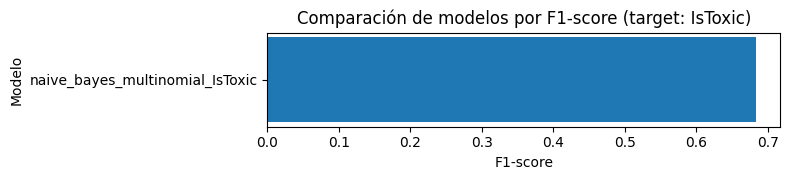

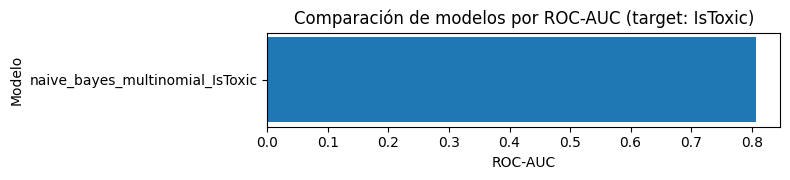


💡 De momento solo hay resultados para **un modelo**: `naive_bayes_multinomial_IsToxic`.

Por eso los gráficos muestran **una única barra**:  
nos sirven para ver el nivel absoluto de **F1-score** y **ROC-AUC**,  
pero todavía **no existe una comparación real entre modelos**.

Cuando el resto de compañeros guarden sus JSON en `data/results/`  
(por ejemplo, `random_forest.json`, `mlp.json`, `roberta.json`, etc.),  
estas mismas figuras mostrarán varias barras (una por modelo) y serán mucho más informativas.


In [6]:
# === 5. Bar plots for F1-score and ROC-AUC ==================================

import matplotlib.pyplot as plt  # Basic plotting

display(Markdown("### 📊 Comparación gráfica de F1-score y ROC-AUC"))

# Number of models in the comparison table
n_models = comparison_df_sorted.shape[0]

# --------- F1-score barh plot -----------------------------------------------
fig, ax = plt.subplots(figsize=(8, 1.5 + 0.4 * n_models))  # Dynamic height
ax.barh(comparison_df_sorted.index, comparison_df_sorted["F1-score"])
ax.set_xlabel("F1-score")
ax.set_ylabel("Modelo")
ax.set_title(f"Comparación de modelos por F1-score (target: {TARGET_LABEL})")
plt.tight_layout()
plt.show()

# --------- ROC-AUC barh plot ------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 1.5 + 0.4 * n_models))  # Dynamic height
ax.barh(comparison_df_sorted.index, comparison_df_sorted["ROC-AUC"])
ax.set_xlabel("ROC-AUC")
ax.set_ylabel("Modelo")
ax.set_title(f"Comparación de modelos por ROC-AUC (target: {TARGET_LABEL})")
plt.tight_layout()
plt.show()

# --------- Explanation depending on #models ---------------------------------
if n_models == 1:
    # Only one model: still valid, but no real comparison yet
    single_model = comparison_df_sorted.index[0]
    display(Markdown(f"""
💡 De momento solo hay resultados para **un modelo**: `{single_model}`.

Por eso los gráficos muestran **una única barra**:  
nos sirven para ver el nivel absoluto de **F1-score** y **ROC-AUC**,  
pero todavía **no existe una comparación real entre modelos**.

Cuando el resto de compañeros guarden sus JSON en `data/results/`  
(por ejemplo, `random_forest.json`, `mlp.json`, `roberta.json`, etc.),  
estas mismas figuras mostrarán varias barras (una por modelo) y serán mucho más informativas.
"""))
else:
    # Several models: real comparison
    display(Markdown("""
**🔎 Interpretación general de las gráficas:**

- Cada barra representa un modelo distinto.
- Cuanto más larga es la barra, mejor rendimiento tiene el modelo en esa métrica.
- Es interesante fijarse en modelos que mantienen **F1-score** y **ROC-AUC** altos a la vez:
  suelen ser los mejores candidatos para pasar a producción.
"""))


### 6. Visualización global: gráfico radar (múltiples métricas)

Para tener una visión más global:

- Construimos un **gráfico radar** (también llamado spider chart) donde:
  - Cada eje es una métrica: Accuracy, Precision, Recall, F1-score, ROC-AUC.
  - Cada "polígono" corresponde a un modelo.

Para evitar un gráfico demasiado recargado, usaremos sólo los **N mejores modelos**
(según F1-score). Por defecto, tomaremos los **3 mejores**.


### 🕸️ Comparativa global de métricas (Radar Chart) – Top 1 modelos

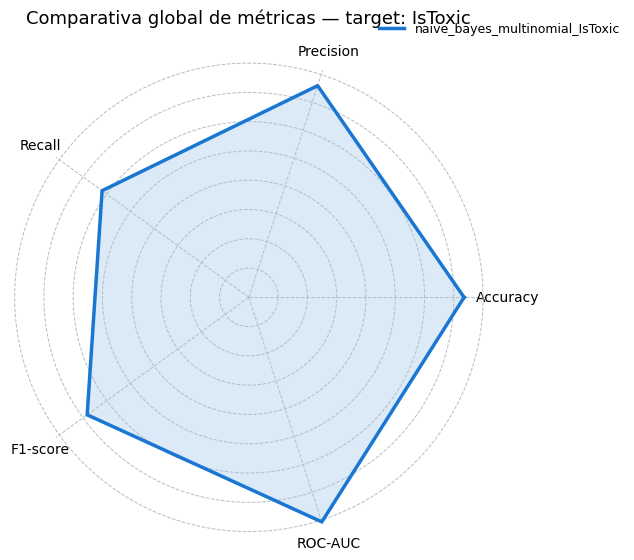


**💬 Conclusión visual:**

En este gráfico radar podemos ver qué modelos mantienen un mejor **equilibrio global** entre:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

El modelo **naive_bayes_multinomial_IsToxic** fue el mejor según F1-score y ROC-AUC en la tabla anterior,
por lo que es un buen candidato como modelo de referencia para `IsToxic`.
    

In [7]:
# === 6. Radar chart for top models =========================================

# Number of top models to include in the radar chart
TOP_N = min(3, comparison_df_sorted.shape[0])

radar_df = comparison_df_sorted.head(TOP_N)

display(Markdown(
    f"### 🕸️ Comparativa global de métricas (Radar Chart) – Top {TOP_N} modelos"
))

# Metrics (columns) and angles for radar chart
categories = list(radar_df.columns)  # ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # close the polygon

# Create radar chart
fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))

# Color palette (explicitly requested style)
palette = ["#1976D2", "#F4B183", "#81C784", "#BA68C8", "#FFB74D"]

for color, (model_name, row) in zip(palette, radar_df.iterrows()):
    values = row.tolist()
    values += values[:1]  # close polygon
    
    ax.plot(angles, values, linewidth=2.5, linestyle="solid",
            label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

# Set axes and labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])  # hide radial labels
ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)

ax.set_title(
    f"Comparativa global de métricas — target: {TARGET_LABEL}",
    fontsize=13, pad=25
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

display(Markdown(
    f"""
**💬 Conclusión visual:**

En este gráfico radar podemos ver qué modelos mantienen un mejor **equilibrio global** entre:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

El modelo **{best_model_name}** fue el mejor según F1-score y ROC-AUC en la tabla anterior,
por lo que es un buen candidato como modelo de referencia para `{TARGET_LABEL}`.
    """
))


### 7. Matriz de confusión del mejor modelo

Finalmente, vamos a visualizar la **matriz de confusión** del mejor modelo
(según F1-score y ROC-AUC).

- Las filas representan la **clase real**.
- Las columnas representan la **clase predicha**.
- Las celdas contienen el número de ejemplos de cada tipo:
  - TN: verdaderos negativos
  - FP: falsos positivos
  - FN: falsos negativos
  - TP: verdaderos positivos

Esto ayuda a entender **qué tipo de errores** comete el modelo (por ejemplo,
si se le escapan muchos mensajes de odio – FN, o si marca demasiado contenido
no tóxico como tóxico – FP).


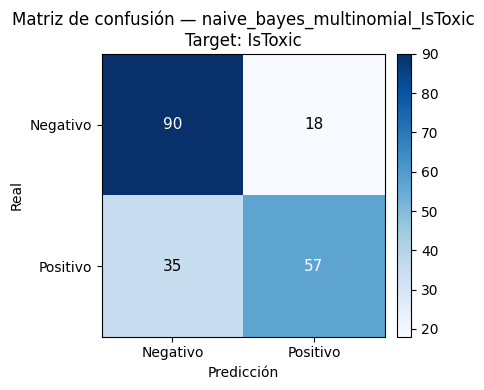


**📌 Detalle de la matriz de confusión (naive_bayes_multinomial_IsToxic):**

- **TN (verdaderos negativos)**: 90
- **FP (falsos positivos)**: 18
- **FN (falsos negativos)**: 35
- **TP (verdaderos positivos)**: 57

Recuerda que en este problema suele ser especialmente importante:

- Minimizar los **FN** (mensajes de odio que el modelo no detecta).
- Controlar los **FP** (mensajes no tóxicos que marcamos como odio).
    

In [8]:
# === 7. Confusion matrix for the best model ================================

# Find the row for the best model in the filtered df_target
best_row_full = df_target[df_target["model_name"] == best_model_name].iloc[0]

# Extract confusion matrix values
tn = int(best_row_full.get("tn", 0))
fp = int(best_row_full.get("fp", 0))
fn = int(best_row_full.get("fn", 0))
tp = int(best_row_full.get("tp", 0))

cm = np.array([[tn, fp],
               [fn, tp]])

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

ax.set_title(f"Matriz de confusión — {best_model_name}\nTarget: {TARGET_LABEL}")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Negativo", "Positivo"])
ax.set_yticklabels(["Negativo", "Positivo"])

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Annotate each cell with its value
thresh = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=11
        )

plt.tight_layout()
plt.show()

display(Markdown(
    f"""
**📌 Detalle de la matriz de confusión ({best_model_name}):**

- **TN (verdaderos negativos)**: {tn}
- **FP (falsos positivos)**: {fp}
- **FN (falsos negativos)**: {fn}
- **TP (verdaderos positivos)**: {tp}

Recuerda que en este problema suele ser especialmente importante:

- Minimizar los **FN** (mensajes de odio que el modelo no detecta).
- Controlar los **FP** (mensajes no tóxicos que marcamos como odio).
    """
))


### 8. Resumen final e integración con el flujo del proyecto

En este bloque final:

- Resumimos qué hemos hecho en este notebook de comparación.
- Interpretamos el comportamiento del **mejor modelo encontrado** para la etiqueta objetivo.
- Explicamos cómo se conecta el `model_name` con:
  - el fichero JSON de resultados en `data/results/`
  - y el fichero `.pkl` del modelo entrenado en `backend/models/`.


In [9]:
# === 8. Final summary and next steps ========================================

display(Markdown("### 🧾 Resumen final y siguientes pasos"))

# Extract metrics for the best model
best_acc = best_model_row["Accuracy"]
best_prec = best_model_row["Precision"]
best_rec = best_model_row["Recall"]
best_f1 = best_model_row["F1-score"]
best_roc = best_model_row["ROC-AUC"]

# Simple rule-based interpretation: does the model favor recall or precision?
if best_rec >= best_prec + 0.03:
    focus_msg = (
        "Este modelo está más orientado a **capturar la mayor cantidad posible de mensajes tóxicos** "
        "(recall relativamente alto), aunque eso pueda generar algún falso positivo adicional."
    )
elif best_prec >= best_rec + 0.03:
    focus_msg = (
        "Este modelo está más orientado a **evitar falsos positivos** "
        "(precisión relativamente alta), aunque eso implique dejar escapar algunos "
        "comentarios tóxicos."
    )
else:
    focus_msg = (
        "Este modelo mantiene un **equilibrio razonable entre precisión y recall**, "
        "lo que lo hace adecuado como modelo generalista para producción."
    )

display(Markdown(f"""
1. ✅ Hemos cargado todos los resultados JSON desde `data/results/` y los hemos unido en un único DataFrame.
2. ✅ Hemos filtrado por la etiqueta objetivo **`{TARGET_LABEL}`** y construido una tabla comparativa de métricas.
3. ✅ Hemos ordenado los modelos por **F1-score** (y en caso de empate, por **ROC-AUC**) y hemos seleccionado el mejor:

   - 🏷️ Modelo: **`{best_model_name}`**
   - Accuracy: **{best_acc:.3f}**
   - Precision: **{best_prec:.3f}**
   - Recall: **{best_rec:.3f}**
   - F1-score: **{best_f1:.3f}**
   - ROC-AUC: **{best_roc:.3f}**

4. 📌 Interpretación del comportamiento del mejor modelo:

   {focus_msg}

5. 🔁 Relación con los ficheros `.pkl` y el despliegue:

   - Cada notebook de modelado (Naive Bayes, Random Forest, MLP, BERT, etc.) debería:
     - Guardar su **pipeline completo** (vectorizador + modelo + cualquier preprocesado)
       en `backend/models/<model_name>.pkl`.
     - Guardar sus métricas y detalles de entrenamiento en
       `data/results/<model_name>.json` siguiendo el mismo esquema de JSON.
   - De esta forma, el campo `model_name` que vemos en este notebook actúa como **puente**:
     - entre el JSON que estamos analizando aquí, y  
     - el `.pkl` que utilizará la API o el servicio en producción.

---

**Siguiente paso recomendado:**

- Cada ejecución del notebook de un modelo:
  - genera su `.json` en `data/results/`, y
  - serializa su modelo en `backend/models/`.
- Volver a lanzar este notebook cuando haya varios JSON para disponer de una
  **comparativa global real de todos los modelos** antes de decidir cuál pasa a producción.
"""))


### 🧾 Resumen final y siguientes pasos


1. ✅ Hemos cargado todos los resultados JSON desde `data/results/` y los hemos unido en un único DataFrame.
2. ✅ Hemos filtrado por la etiqueta objetivo **`IsToxic`** y construido una tabla comparativa de métricas.
3. ✅ Hemos ordenado los modelos por **F1-score** (y en caso de empate, por **ROC-AUC**) y hemos seleccionado el mejor:

   - 🏷️ Modelo: **`naive_bayes_multinomial_IsToxic`**
   - Accuracy: **0.735**
   - Precision: **0.760**
   - Recall: **0.620**
   - F1-score: **0.683**
   - ROC-AUC: **0.806**

4. 📌 Interpretación del comportamiento del mejor modelo:

   Este modelo está más orientado a **evitar falsos positivos** (precisión relativamente alta), aunque eso implique dejar escapar algunos comentarios tóxicos.

5. 🔁 Relación con los ficheros `.pkl` y el despliegue:

   - Cada notebook de modelado (Naive Bayes, Random Forest, MLP, BERT, etc.) debería:
     - Guardar su **pipeline completo** (vectorizador + modelo + cualquier preprocesado)
       en `backend/models/<model_name>.pkl`.
     - Guardar sus métricas y detalles de entrenamiento en
       `data/results/<model_name>.json` siguiendo el mismo esquema de JSON.
   - De esta forma, el campo `model_name` que vemos en este notebook actúa como **puente**:
     - entre el JSON que estamos analizando aquí, y  
     - el `.pkl` que utilizará la API o el servicio en producción.

---

**Siguiente paso recomendado:**

- Cada ejecución del notebook de un modelo:
  - genera su `.json` en `data/results/`, y
  - serializa su modelo en `backend/models/`.
- Volver a lanzar este notebook cuando haya varios JSON para disponer de una
  **comparativa global real de todos los modelos** antes de decidir cuál pasa a producción.
